In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import zipfile, os

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nanadanizulkuta","key":"ce8f75ddc55cd1fad372a8e7b7d24584"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
# Menyalin kaggle.json ke dalam folder yang sudah dibuat 
! cp kaggle.json ~/.kaggle/

In [ ]:
# Memberikan izin untuk json bertindak 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Mengunduh Dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 670M/675M [00:04<00:00, 165MB/s]
100% 675M/675M [00:04<00:00, 165MB/s]


In [ ]:
# Mengekstrak berkas zip ke direktori aktif 
!unzip /content/cell-images-for-detecting-malaria.zip

In [ ]:
base_dir="cell_images/cell_images"

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(base_dir)
for klass in classlist:
    classpath=os.path.join(base_dir,klass)
    flist=os.listdir(classpath)
    for f in flist:        
        fpath=os.path.join(classpath,f) 
        if klass != 'cell_images':
            filepaths.append(fpath)        
            labels.append(klass)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  27560    labels:  27560


In [ ]:
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print(df.tail())
vcounts=df['labels'].value_counts()
print (vcounts)
vcounts=list(vcounts)
vmin=np.min(vcounts)
print (vmin)
classes=df['labels'].unique()
class_count=len(classes)

                                           filepaths       labels
0  cell_images/cell_images/Parasitized/C80P41Thin...  Parasitized
1  cell_images/cell_images/Parasitized/C70P31_Thi...  Parasitized
2  cell_images/cell_images/Parasitized/C115P76Thi...  Parasitized
3  cell_images/cell_images/Parasitized/C128P89Thi...  Parasitized
4  cell_images/cell_images/Parasitized/C176P137NT...  Parasitized
                                               filepaths      labels
27555  cell_images/cell_images/Uninfected/C138P99Thin...  Uninfected
27556  cell_images/cell_images/Uninfected/C217ThinF_I...  Uninfected
27557  cell_images/cell_images/Uninfected/C155P116Thi...  Uninfected
27558  cell_images/cell_images/Uninfected/C227ThinF_I...  Uninfected
27559  cell_images/cell_images/Uninfected/C205ThinF_I...  Uninfected
Uninfected     13780
Parasitized    13780
Name: labels, dtype: int64
13780


In [ ]:
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df))
print (df['labels'].value_counts())

train samples:  24804   test samples:  1378  validation samples 1378
Uninfected     13780
Parasitized    13780
Name: labels, dtype: int64


In [ ]:
file_count = 1000
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts()) # check to see each class has 200 samples
print (len(df))

Parasitized    1000
Uninfected     1000
Name: labels, dtype: int64
2000


In [ ]:
height=150
width=140
channels=3
batch_size=80
img_shape=(height, width, channels)
img_size=(height, width)

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)

train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', 
                                    y_col='labels', 
                                    target_size=img_size, 
                                    class_mode='categorical',
                                    color_mode='rgb', 
                                    shuffle=False, 
                                    batch_size=batch_size)

test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', 
                                   y_col='labels', 
                                   target_size=img_size, 
                                   class_mode='categorical',
                                   color_mode='rgb', 
                                   shuffle=False, 
                                   batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  53   test steps:  26
Found 24802 validated image filenames belonging to 2 classes.
Found 1378 validated image filenames belonging to 2 classes.
Found 1378 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
print(class_count)

2


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')        
])

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

TypeError: ignored

In [ ]:
history=model.fit(x=train_gen,
                   epochs = 5,
                   validation_data = valid_gen)

Epoch 1/5
311/311 [==============================] - 87s 262ms/step - loss: 0.3300 - accuracy: 0.8598 - val_loss: 0.1758 - val_accuracy: 0.9456
Epoch 2/5
311/311 [==============================] - 80s 257ms/step - loss: 0.2118 - accuracy: 0.9314 - val_loss: 0.1771 - val_accuracy: 0.9463
Epoch 3/5
311/311 [==============================] - 80s 257ms/step - loss: 0.1927 - accuracy: 0.9373 - val_loss: 0.1586 - val_accuracy: 0.9470
Epoch 4/5
311/311 [==============================] - 80s 257ms/step - loss: 0.1961 - accuracy: 0.9381 - val_loss: 0.1531 - val_accuracy: 0.9492
Epoch 5/5
311/311 [==============================] - 80s 257ms/step - loss: 0.1914 - accuracy: 0.9380 - val_loss: 0.1584 - val_accuracy: 0.9499


In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

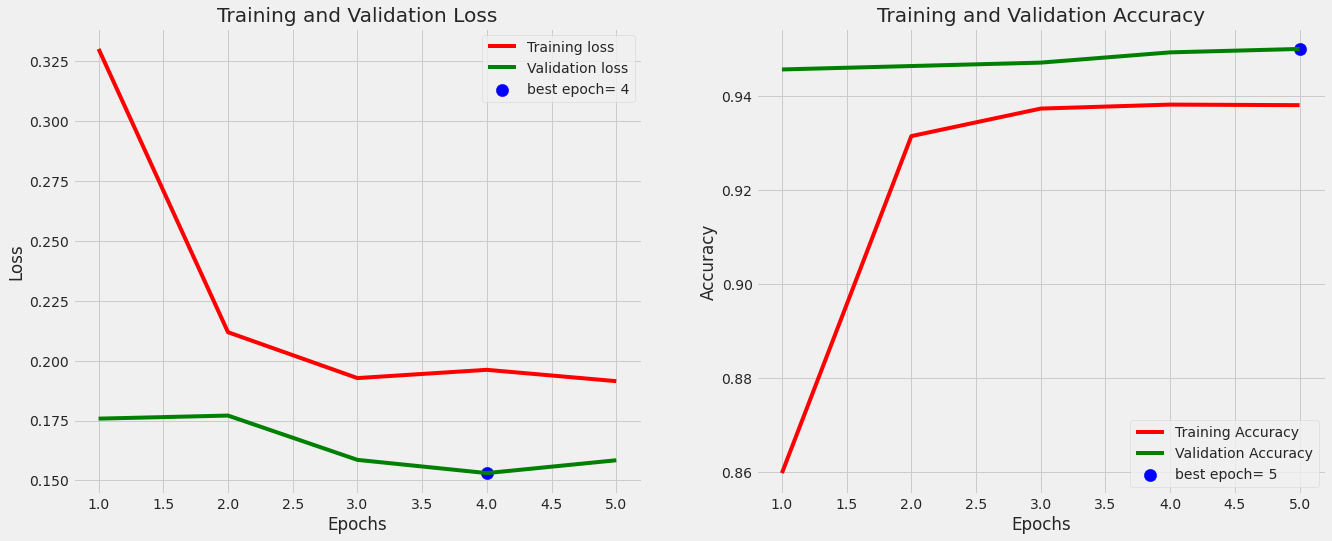

26/26 [==============================] - 4s 90ms/step - loss: 0.1532 - accuracy: 0.9499
Model accuracy on test set: 94.99274492263794



In [ ]:
tr_plot(history, 0)
acc=model.evaluate(test_gen, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print_in_color(msg, (0,255,0), (55,65,80))

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)        
        length=len(classes)
        if length<25:
            if length<8:
                fig_width=8
                fig_height=8
            else:
                fig_width= int(length * .5)
                fig_height= int(length * .5)
            plt.figure(figsize=(fig_width, fig_height))
            sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
            plt.xticks(np.arange(length)+.5, classes, rotation= 90)
            plt.yticks(np.arange(length)+.5, classes, rotation=0)
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix")
            plt.show()    
        print("Classification Report:\n----------------------\n", clr)

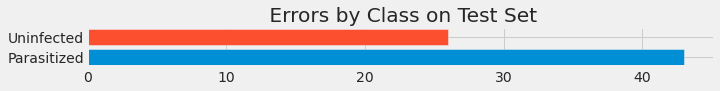

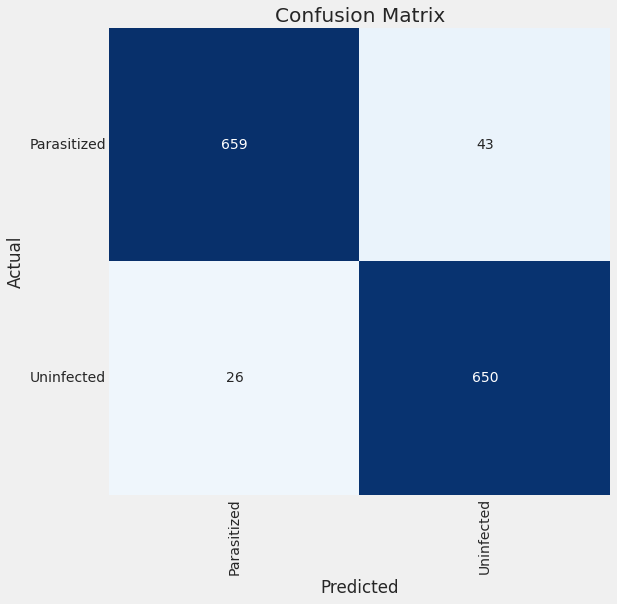

Classification Report:
----------------------
               precision    recall  f1-score   support

 Parasitized       0.96      0.94      0.95       702
  Uninfected       0.94      0.96      0.95       676

    accuracy                           0.95      1378
   macro avg       0.95      0.95      0.95      1378
weighted avg       0.95      0.95      0.95      1378



In [ ]:
save_dir=r'./'
subject='malaria'
print_code=0
preds=model.predict(test_gen, steps=test_steps) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#VGG-16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (150, 150, 3), # Shape of our images
                  include_top = False, # Leave out the last fully connected layer
                  weights = 'imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False


import tensorflow as tf
from tensorflow import keras

# pretrained_model.summary()
# last_layer = base_model.get_layer('block5_pool')
# last_output= last_layer.output

x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)                  
x = keras.layers.Dense(2, activation='softmax')(x)           

modelVGG = tf.keras.models.Model(base_model.input, x)

modelVGG.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',metrics = ['accuracy'])
#modelVGG.summary()

history_VGG=modelVGG.fit(train_gen,
                   epochs = 5,
                   validation_data = valid_gen)

Epoch 1/5
311/311 [==============================] - 97s 308ms/step - loss: 0.6611 - accuracy: 0.8460 - val_loss: 0.2267 - val_accuracy: 0.8991
Epoch 2/5
311/311 [==============================] - 95s 306ms/step - loss: 0.2159 - accuracy: 0.9196 - val_loss: 0.2849 - val_accuracy: 0.8730
Epoch 3/5
311/311 [==============================] - 95s 306ms/step - loss: 0.1839 - accuracy: 0.9321 - val_loss: 0.1419 - val_accuracy: 0.9485
Epoch 4/5
311/311 [==============================] - 95s 305ms/step - loss: 0.1747 - accuracy: 0.9358 - val_loss: 0.1388 - val_accuracy: 0.9485
Epoch 5/5
311/311 [==============================] - 95s 306ms/step - loss: 0.1626 - accuracy: 0.9412 - val_loss: 0.1291 - val_accuracy: 0.9557


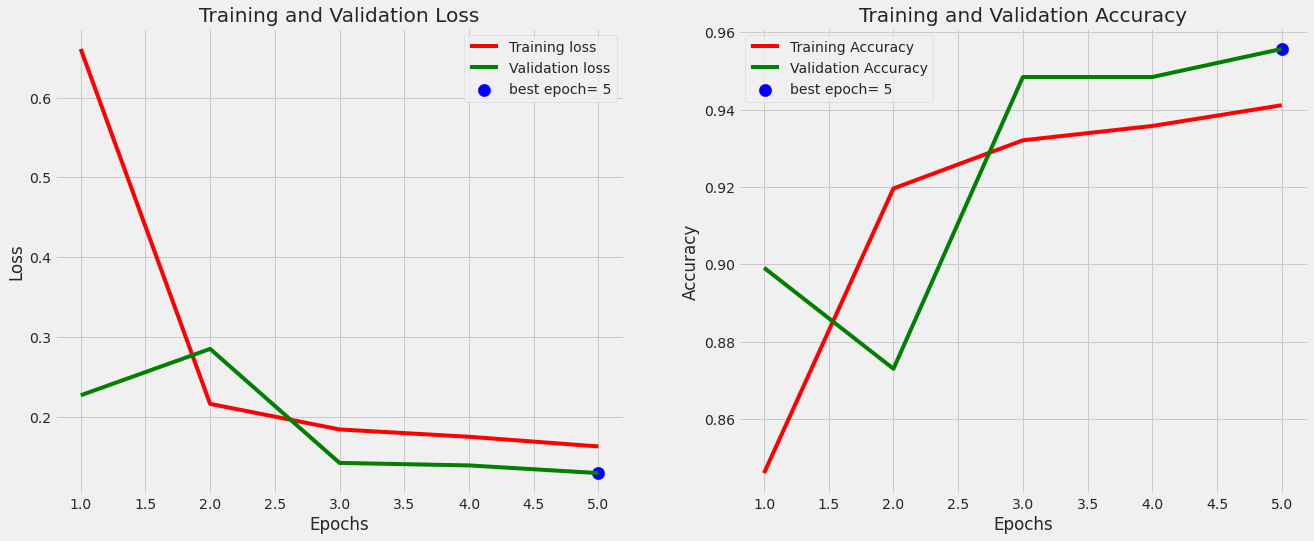

26/26 [==============================] - 6s 215ms/step - loss: 0.1351 - accuracy: 0.9579
Model accuracy on test set: 95.79100012779236



In [ ]:
tr_plot(history_VGG, 0)
acc=modelVGG.evaluate(test_gen, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print_in_color(msg, (0,255,0), (55,65,80))

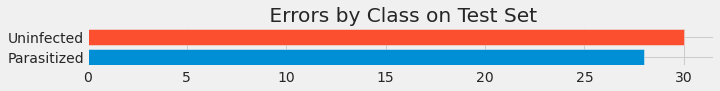

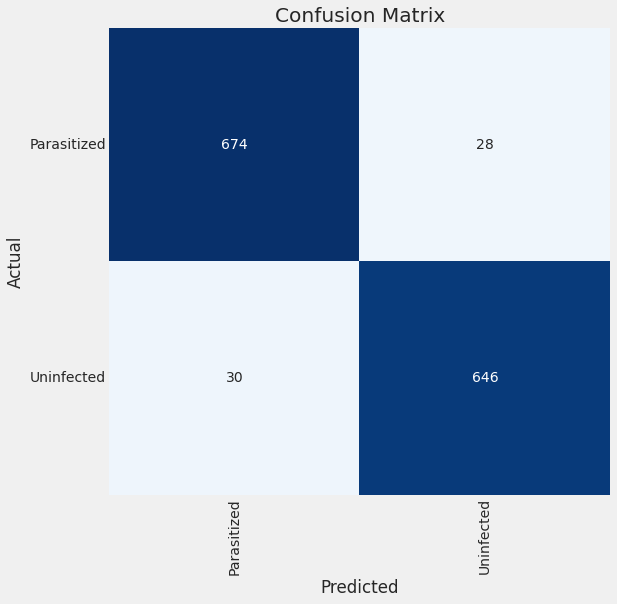

Classification Report:
----------------------
               precision    recall  f1-score   support

 Parasitized       0.96      0.96      0.96       702
  Uninfected       0.96      0.96      0.96       676

    accuracy                           0.96      1378
   macro avg       0.96      0.96      0.96      1378
weighted avg       0.96      0.96      0.96      1378



In [ ]:
save_dir=r'./'
subject='malaria'
print_code=0
preds=modelVGG.predict(test_gen, steps=test_steps) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#Fine Tuning VGG

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
modelVGG.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history_fine = modelVGG.fit(train_gen,
                   epochs=10,
                   initial_epoch=history_VGG.epoch[-1],
                   validation_data = valid_gen)

Epoch 5/10
311/311 [==============================] - 96s 306ms/step - loss: 0.1272 - accuracy: 0.9557 - val_loss: 0.1229 - val_accuracy: 0.9550
Epoch 6/10
311/311 [==============================] - 95s 305ms/step - loss: 0.1230 - accuracy: 0.9574 - val_loss: 0.1221 - val_accuracy: 0.9565
Epoch 7/10
311/311 [==============================] - 95s 306ms/step - loss: 0.1227 - accuracy: 0.9561 - val_loss: 0.1217 - val_accuracy: 0.9550
Epoch 8/10
311/311 [==============================] - 95s 306ms/step - loss: 0.1227 - accuracy: 0.9572 - val_loss: 0.1215 - val_accuracy: 0.9557
Epoch 9/10
311/311 [==============================] - 95s 305ms/step - loss: 0.1211 - accuracy: 0.9581 - val_loss: 0.1214 - val_accuracy: 0.9550
Epoch 10/10
311/311 [==============================] - 95s 305ms/step - loss: 0.1213 - accuracy: 0.9575 - val_loss: 0.1213 - val_accuracy: 0.9572


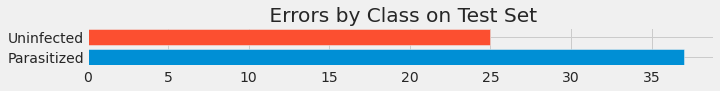

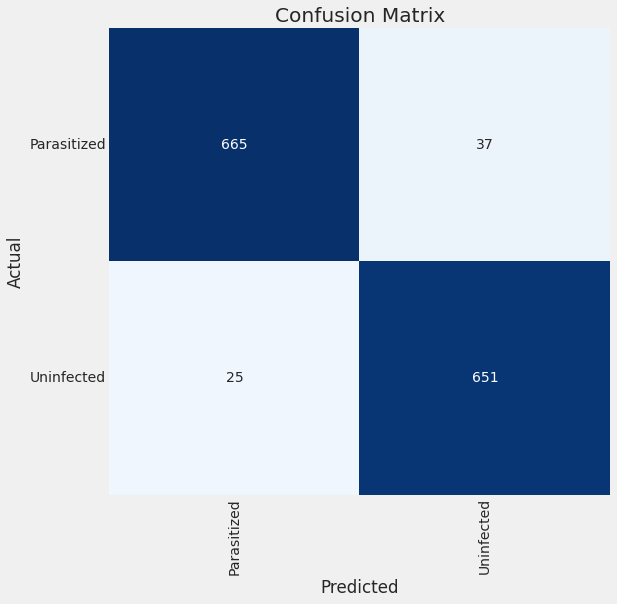

Classification Report:
----------------------
               precision    recall  f1-score   support

 Parasitized       0.96      0.95      0.96       702
  Uninfected       0.95      0.96      0.95       676

    accuracy                           0.96      1378
   macro avg       0.95      0.96      0.96      1378
weighted avg       0.96      0.96      0.96      1378



In [ ]:
save_dir=r'./'
subject='malaria'
print_code=0
preds=modelVGG.predict(test_gen, steps=test_steps) 
print_info( test_gen, preds, print_code, save_dir, subject ) 

#Resnet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model=ResNet50(weights='imagenet',include_top=False,input_shape=(150,150,3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
for layer in resnet_model.layers:
    layer.trainable = False
      
# last_layer = resnet_model.get_layer('conv5_block3_out')
# last_output = last_layer.output

x = keras.layers.Flatten()(resnet_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)                  
x = keras.layers.Dense(2, activation='softmax')(x) 
modelResnet = tf.keras.models.Model(resnet_model.input, x)  

modelResnet.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',metrics = ['accuracy'])
#modelResnet.summary()

history_resnet=modelResnet.fit(train_gen,
                   epochs = 5,
                   validation_data = valid_gen)

Epoch 1/5
311/311 [==============================] - 106s 324ms/step - loss: 2.3880 - accuracy: 0.6125 - val_loss: 0.6795 - val_accuracy: 0.6408
Epoch 2/5
311/311 [==============================] - 99s 317ms/step - loss: 0.6198 - accuracy: 0.6738 - val_loss: 0.5437 - val_accuracy: 0.7308
Epoch 3/5
311/311 [==============================] - 98s 316ms/step - loss: 0.5865 - accuracy: 0.6977 - val_loss: 0.5357 - val_accuracy: 0.7286
Epoch 4/5
311/311 [==============================] - 98s 316ms/step - loss: 0.5649 - accuracy: 0.7148 - val_loss: 0.5132 - val_accuracy: 0.7482
Epoch 5/5
311/311 [==============================] - 98s 316ms/step - loss: 0.5443 - accuracy: 0.7270 - val_loss: 0.4762 - val_accuracy: 0.7707


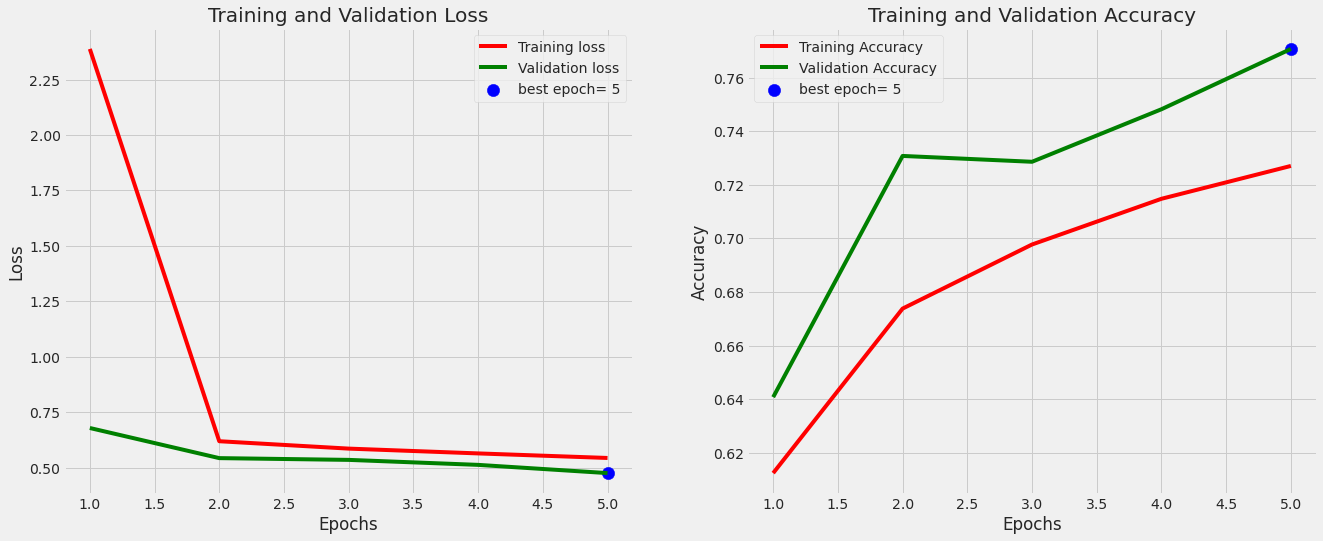

26/26 [==============================] - 6s 194ms/step - loss: 0.4620 - accuracy: 0.7714
Model accuracy on test set: 77.14078426361084



In [ ]:
tr_plot(history_resnet, 0)
acc=modelResnet.evaluate(test_gen, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print_in_color(msg, (0,255,0), (55,65,80))

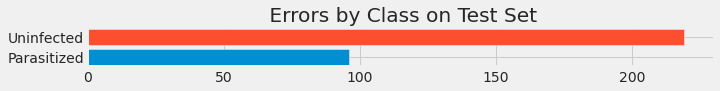

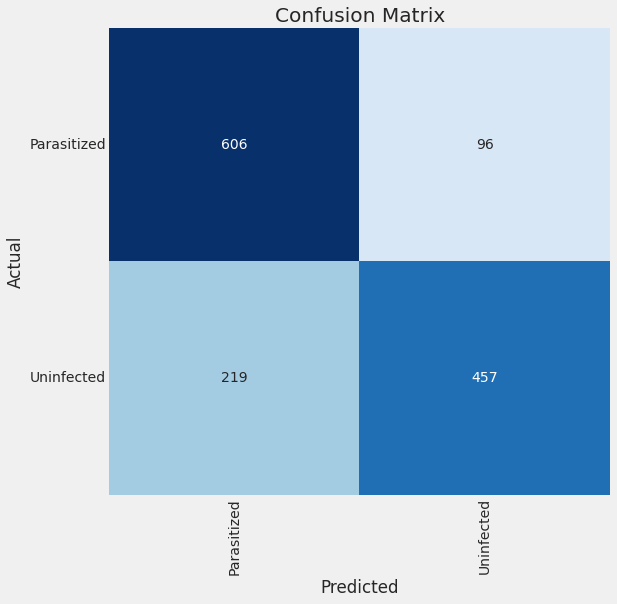

Classification Report:
----------------------
               precision    recall  f1-score   support

 Parasitized       0.73      0.86      0.79       702
  Uninfected       0.83      0.68      0.74       676

    accuracy                           0.77      1378
   macro avg       0.78      0.77      0.77      1378
weighted avg       0.78      0.77      0.77      1378



In [ ]:
save_dir=r'./'
subject='malaria'
print_code=0
preds=modelResnet.predict(test_gen, steps=test_steps) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#Inception

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(input_shape = (150, 150, 3),
                                    weights='imagenet',
                                    include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception_model.layers:
        layer.trainable = False


# last_layer =  inception_model.get_layer('mixed7')
# last_output = last_layer.output

x = keras.layers.Flatten()(inception_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(2, activation='softmax')(x)

modelInception = tf.keras.models.Model(inception_model.input, x)

modelInception.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',metrics = ['accuracy'])
# modelResnet.summary()
historyInception=modelInception.fit(train_gen,
                    epochs = 5,
                    validation_data = valid_gen)

Epoch 1/5
311/311 [==============================] - 69s 199ms/step - loss: 1.1995 - accuracy: 0.8648 - val_loss: 0.2037 - val_accuracy: 0.9180
Epoch 2/5
311/311 [==============================] - 59s 188ms/step - loss: 0.2524 - accuracy: 0.9086 - val_loss: 0.1903 - val_accuracy: 0.9332
Epoch 3/5
311/311 [==============================] - 59s 189ms/step - loss: 0.2203 - accuracy: 0.9186 - val_loss: 0.2057 - val_accuracy: 0.9238
Epoch 4/5
311/311 [==============================] - 59s 188ms/step - loss: 0.1975 - accuracy: 0.9265 - val_loss: 0.1922 - val_accuracy: 0.9318
Epoch 5/5
311/311 [==============================] - 59s 189ms/step - loss: 0.1949 - accuracy: 0.9307 - val_loss: 0.2226 - val_accuracy: 0.9216


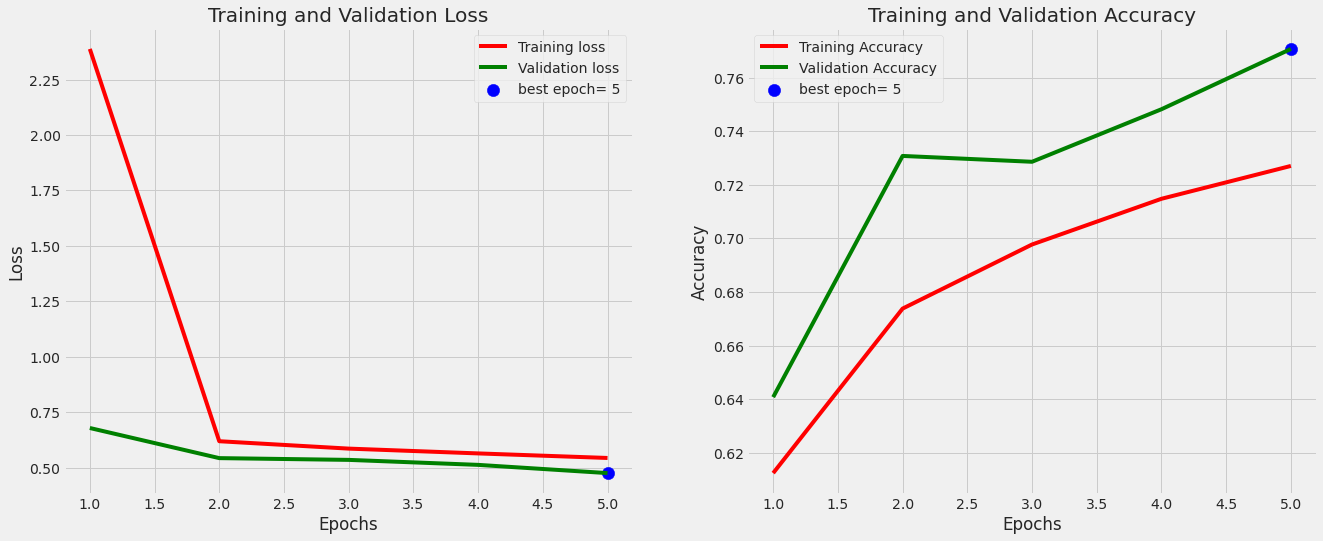

26/26 [==============================] - 5s 125ms/step - loss: 0.2084 - accuracy: 0.9311
Model accuracy on test set: 93.105947971344



In [ ]:
tr_plot(history_resnet, 0)
acc=modelInception.evaluate(test_gen, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print_in_color(msg, (0,255,0), (55,65,80))

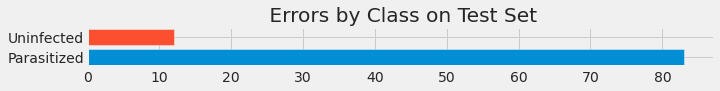

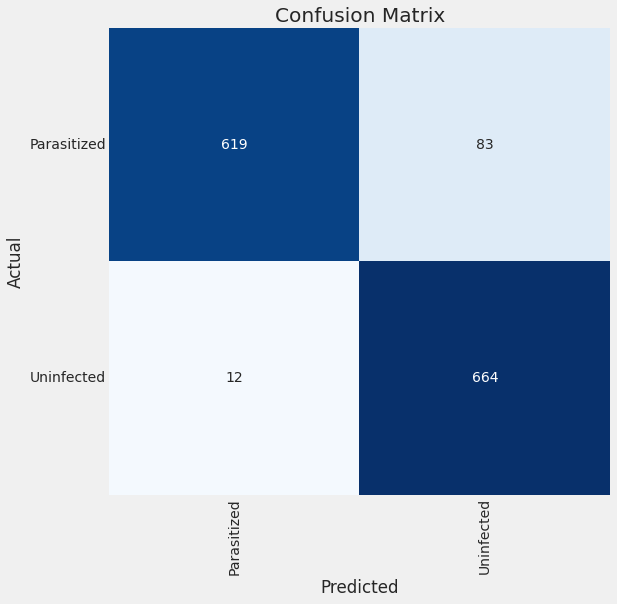

Classification Report:
----------------------
               precision    recall  f1-score   support

 Parasitized       0.98      0.88      0.93       702
  Uninfected       0.89      0.98      0.93       676

    accuracy                           0.93      1378
   macro avg       0.93      0.93      0.93      1378
weighted avg       0.94      0.93      0.93      1378



In [ ]:
save_dir=r'./'
subject='malaria'
print_code=0
preds=modelInception.predict(test_gen, steps=test_steps) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#Xception

In [ ]:
from tensorflow.keras.applications.xception import Xception
xception_model=Xception(weights='imagenet',include_top=False,input_shape=(150,150,3))

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import tensorflow as tf
from tensorflow import keras

for layer in xception_model.layers:
    xception_model.trainable = False
      
# last_layer = resnet_model.get_layer('conv5_block3_out')
# last_output = last_layer.output

x = keras.layers.Flatten()(xception_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)                  
x = keras.layers.Dense(2, activation='sigmoid')(x) 
modelXception = tf.keras.models.Model(xception_model.input, x)  

modelXception.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',metrics = ['accuracy'])
#modelResnet.summary()

history_xception=modelXception.fit(train_gen,
                   epochs = 5,
                   validation_data = valid_gen)

Epoch 1/5
311/311 [==============================] - 120s 368ms/step - loss: 2.6574 - accuracy: 0.8803 - val_loss: 0.1763 - val_accuracy: 0.9347
Epoch 2/5
311/311 [==============================] - 113s 362ms/step - loss: 0.2551 - accuracy: 0.9160 - val_loss: 0.1655 - val_accuracy: 0.9419
Epoch 3/5
311/311 [==============================] - 113s 363ms/step - loss: 0.2163 - accuracy: 0.9271 - val_loss: 0.1802 - val_accuracy: 0.9470
Epoch 4/5
311/311 [==============================] - 112s 361ms/step - loss: 0.1950 - accuracy: 0.9339 - val_loss: 0.1906 - val_accuracy: 0.9405
Epoch 5/5
311/311 [==============================] - 112s 361ms/step - loss: 0.1879 - accuracy: 0.9369 - val_loss: 0.1887 - val_accuracy: 0.9456


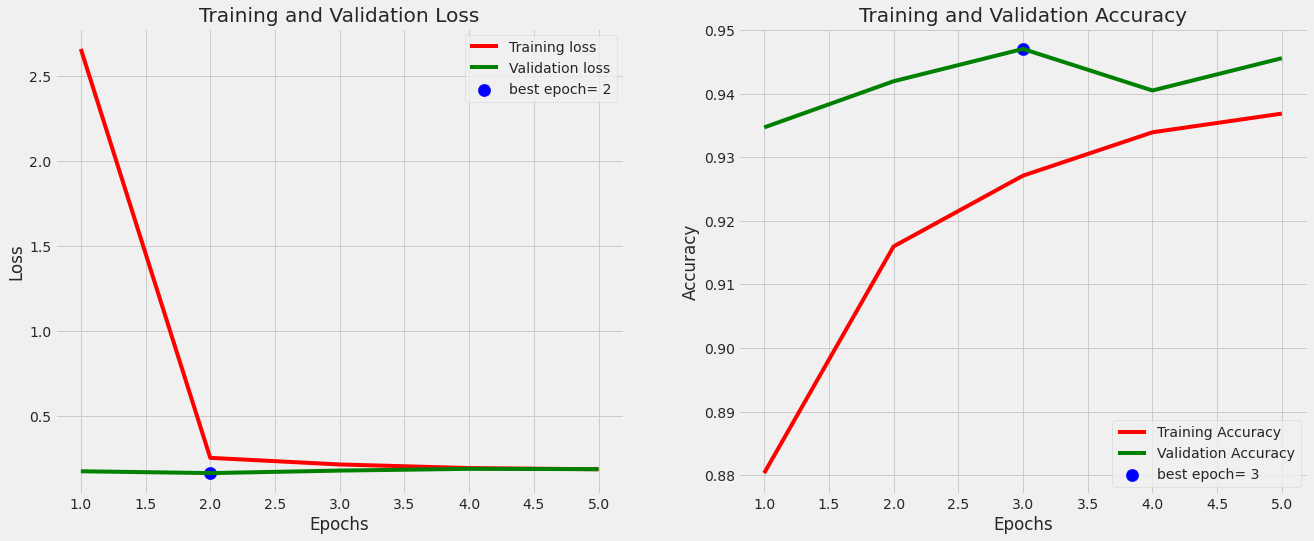

26/26 [==============================] - 7s 217ms/step - loss: 0.1599 - accuracy: 0.9485
Model accuracy on test set: 94.84760761260986



In [ ]:
tr_plot(history_xception, 0)
acc=modelXception.evaluate(test_gen, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print_in_color(msg, (0,255,0), (55,65,80))

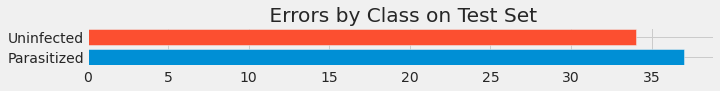

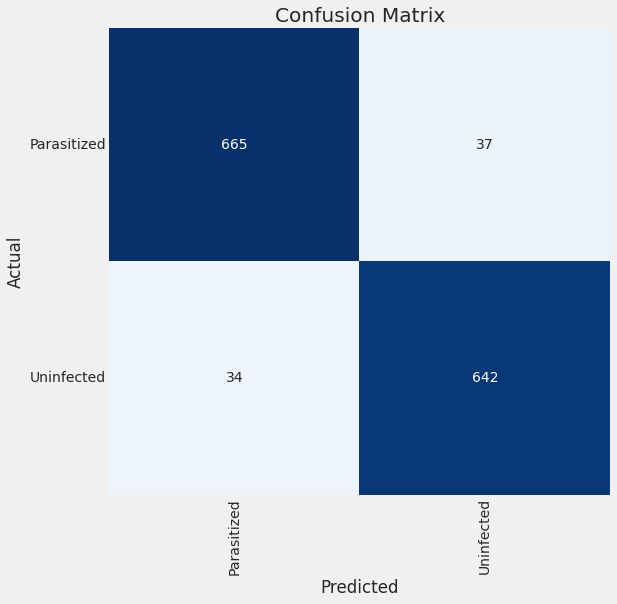

Classification Report:
----------------------
               precision    recall  f1-score   support

 Parasitized       0.95      0.95      0.95       702
  Uninfected       0.95      0.95      0.95       676

    accuracy                           0.95      1378
   macro avg       0.95      0.95      0.95      1378
weighted avg       0.95      0.95      0.95      1378



In [ ]:
save_dir=r'./'
subject='malaria'
print_code=0
preds=modelXception.predict(test_gen, steps=test_steps) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#VGG-19

In [ ]:
# from tensorflow.keras.applications.NASNetMobile import NASNetMobile
vgg19_model = tf.keras.applications.VGG19(input_shape = (150, 150, 3),
                                    weights='imagenet',
                                    include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg19_model.layers:
        layer.trainable = False


# last_layer =  inception_model.get_layer('mixed7')
# last_output = last_layer.output

x = keras.layers.Flatten()(vgg19_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(2, activation='softmax')(x)

modelVgg19 = tf.keras.models.Model(vgg19_model.input, x)

modelVgg19.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',metrics = ['accuracy'])
# modelResnet.summary()

modelVgg19.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',metrics = ['accuracy'])
historyVGG19=modelVgg19.fit(train_gen,
                    epochs = 5,
                    validation_data = valid_gen)

Epoch 1/5
311/311 [==============================] - 115s 365ms/step - loss: 0.6666 - accuracy: 0.8124 - val_loss: 0.4558 - val_accuracy: 0.8128
Epoch 2/5
311/311 [==============================] - 113s 364ms/step - loss: 0.2478 - accuracy: 0.9027 - val_loss: 0.2281 - val_accuracy: 0.9100
Epoch 3/5
311/311 [==============================] - 113s 364ms/step - loss: 0.2063 - accuracy: 0.9217 - val_loss: 0.1479 - val_accuracy: 0.9376
Epoch 4/5
311/311 [==============================] - 113s 364ms/step - loss: 0.1980 - accuracy: 0.9272 - val_loss: 0.2341 - val_accuracy: 0.9042
Epoch 5/5
311/311 [==============================] - 113s 364ms/step - loss: 0.1807 - accuracy: 0.9300 - val_loss: 0.1445 - val_accuracy: 0.9478


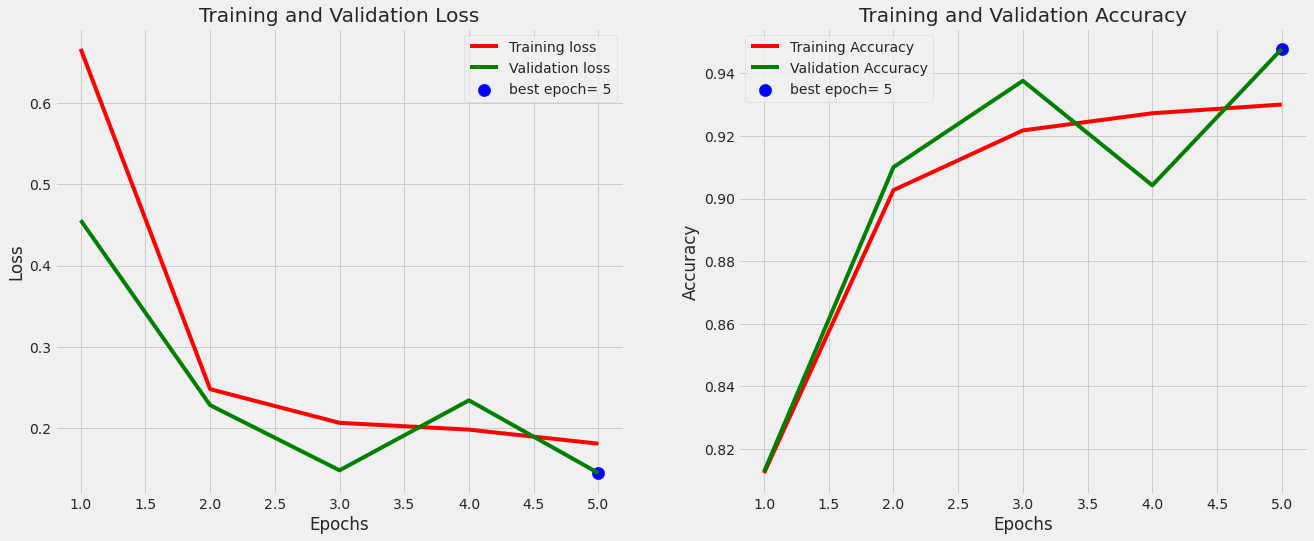

26/26 [==============================] - 7s 259ms/step - loss: 0.1409 - accuracy: 0.9470
Model accuracy on test set: 94.70247030258179



In [ ]:
tr_plot(historyVGG19, 0)
acc=modelVgg19.evaluate(test_gen, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print_in_color(msg, (0,255,0), (55,65,80))

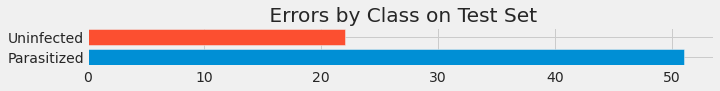

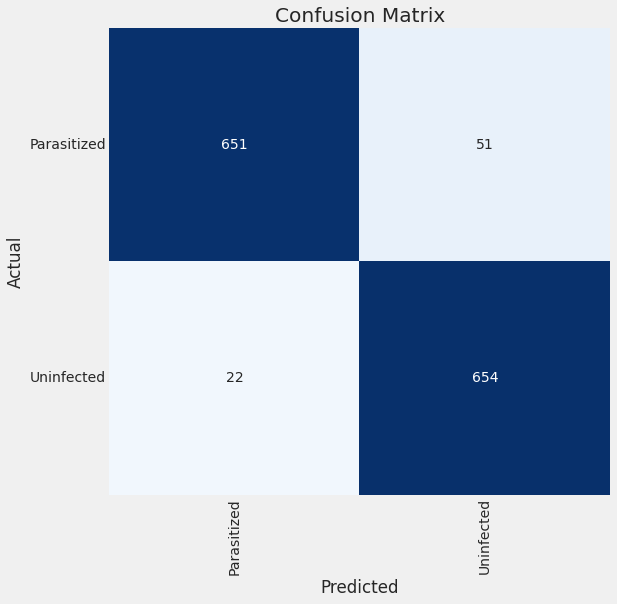

Classification Report:
----------------------
               precision    recall  f1-score   support

 Parasitized       0.97      0.93      0.95       702
  Uninfected       0.93      0.97      0.95       676

    accuracy                           0.95      1378
   macro avg       0.95      0.95      0.95      1378
weighted avg       0.95      0.95      0.95      1378



In [ ]:
save_dir=r'./'
subject='malaria'
print_code=0
preds=modelVgg19.predict(test_gen, steps=test_steps) 
print_info( test_gen, preds, print_code, save_dir, subject )  